In [1]:
from __future__ import print_function

#Exploring Topics in Data Science

##Using counters

###1: Counters

A counter is a map from values to their frequencies. If you initialize a counter with a string, you get a map from each letter to the number of times it appears. If two words are anagrams, they yield equal Counters, so you can use Counters to test anagrams in linear time.

This lesson is based on an <a href = "https://github.com/AllenDowney/PythonCounterPmf">ipython notebook by Allen Downey</a>.

In [2]:
from collections import Counter

def is_anagram(word1, word2):
    """Checks whether the words are anagrams.

    word1: string
    word2: string

    returns: boolean
    """
    return Counter(word1) == Counter(word2)

print("is_anagram('tachymetric', 'mccarthyite'):", is_anagram('tachymetric', 'mccarthyite'))
print("is_anagram('banana', 'peach'):", is_anagram('banana', 'peach'))

is_anagram('tachymetric', 'mccarthyite'): True
is_anagram('banana', 'peach'): False


###2: Multisets

A Counter is a natural representation of a multiset, which is a set where the elements can appear more than once. You can extend Counter with set operations like is_subset.

For example, you could use is_subset in a game like Scrabble to see if a given set of tiles can be used to spell a given word.

In [3]:
class Multiset(Counter):
    """A multiset is a set where elements can appear more than once."""

    def is_subset(self, other):
        """Checks whether self is a subset of other.

        other: Multiset

        returns: boolean
        """
        for char, count in self.items():
            if other[char] < count:
                return False
        return True
    
    # map the <= operator to is_subset
    __le__ = is_subset

def can_spell(word, tiles):
    """Checks whether a set of tiles can spell a word.

    word: string
    tiles: string

    returns: boolean
    """
    return Multiset(word) <= Multiset(tiles)

print("can_spell('SYZYGY', 'AGSYYYZ'):", can_spell('SYZYGY', 'AGSYYYZ'))

can_spell('SYZYGY', 'AGSYYYZ'): True


###3: Probability Mass Functions

You can also extend Counter to represent a probability mass function (PMF).

normalize computes the total of the frequencies and divides through, yielding probabilities that add to 1.

__add__ enumerates all pairs of value and returns a new Pmf that represents the distribution of the sum.

__hash__ and __id__ make Pmfs hashable; this is not the best way to do it, because they are mutable. So this implementation comes with a warning that if you use a Pmf as a key, you should not modify it. A better alternative would be to define a frozen Pmf.

render returns the values and probabilities in a form ready for plotting

In [4]:
class Pmf(Counter):
    """A Counter with probabilities."""

    def normalize(self):
        """Normalizes the PMF so the probabilities add to 1."""
        total = float(sum(self.values()))
        for key in self:
            self[key] /= total

    def __add__(self, other):
        """Adds two distributions.

        The result is the distribution of sums of values from the
        two distributions.

        other: Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for key1, prob1 in self.items():
            for key2, prob2 in other.items():
                pmf[key1 + key2] += prob1 * prob2
        return pmf

    def __hash__(self):
        """Returns an integer hash value."""
        return id(self)
    
    def __eq__(self, other):
        return self is other

    def render(self):
        """Returns values and their probabilities, suitable for plotting."""
        return zip(*sorted(self.items()))

###4: Using the Pmf object

As an example, we can make a Pmf object that represents a 6-sided die.

In [5]:
d6 = Pmf([1,2,3,4,5,6])
d6.normalize()
d6.name = 'one die'
print("d6:", d6)

d6: Pmf({1: 0.16666666666666666, 2: 0.16666666666666666, 3: 0.16666666666666666, 4: 0.16666666666666666, 5: 0.16666666666666666, 6: 0.16666666666666666})


###5: Add operator

Using the add operator, we can compute the distribution for the sum of two dice.

In [6]:
d6_twice = d6 + d6
d6_twice.name = 'two dice'

for key, prob in d6_twice.items():
    print(key, prob)

2 0.027777777777777776
3 0.05555555555555555
4 0.08333333333333333
5 0.1111111111111111
6 0.1388888888888889
7 0.16666666666666669
8 0.1388888888888889
9 0.1111111111111111
10 0.08333333333333333
11 0.05555555555555555
12 0.027777777777777776


###6: Computing the distribution

Using numpy.sum, we can compute the distribution for the sum of three dice. And then plot the results (using Pmf.render)

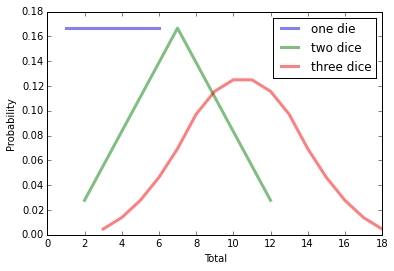

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

pmf_ident = Pmf([0])
d6_thrice = sum([d6]*3, pmf_ident)
d6_thrice.name = 'three dice'

for die in [d6, d6_twice, d6_thrice]:
    xs, ys = die.render()
    plt.plot(xs, ys, label=die.name, linewidth=3, alpha=0.5)
    
plt.xlabel('Total')
plt.ylabel('Probability')
plt.legend()
plt.show()

###7: Bayesian statistics

A Suite is a Pmf that represents a set of hypotheses and their probabilities; it provides bayesian_update, which updates the probability of the hypotheses based on new data.

Suite is an abstract parent class; child classes should provide a likelihood method that evaluates the likelihood of the data under a given hypothesis. update_bayesian loops through the hypothesis, evaluates the likelihood of the data under each hypothesis, and updates the probabilities accordingly. Then it re-normalizes the PMF.

In [8]:
class Suite(Pmf):
    """Map from hypothesis to probability."""

    def bayesian_update(self, data):
        """Performs a Bayesian update.
        
        Note: called bayesian_update to avoid overriding dict.update

        data: result of a die roll
        """
        for hypo in self:
            like = self.likelihood(data, hypo)
            self[hypo] *= like

        self.normalize()

###8: Suite example

As an example, use Suite to solve the "Dice Problem," from Chapter 3 of Think Bayes.

"Suppose I have a box of dice that contains a 4-sided die, a 6-sided die, an 8-sided die, a 12-sided die, and a 20-sided die. If you have ever played Dungeons & Dragons, you know what I am talking about. Suppose I select a die from the box at random, roll it, and get a 6. What is the probability that I rolled each die?"

Start by making a list of Pmfs to represent the dice:

In [9]:
def make_die(num_sides):
    die = Pmf(range(1, num_sides+1))
    die.name = 'd%d' % num_sides
    die.normalize()
    return die

dice = [make_die(x) for x in [4, 6, 8, 12, 20]]
print("dice:", dice)

dice: [Pmf({1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25}), Pmf({1: 0.16666666666666666, 2: 0.16666666666666666, 3: 0.16666666666666666, 4: 0.16666666666666666, 5: 0.16666666666666666, 6: 0.16666666666666666}), Pmf({1: 0.125, 2: 0.125, 3: 0.125, 4: 0.125, 5: 0.125, 6: 0.125, 7: 0.125, 8: 0.125}), Pmf({1: 0.08333333333333333, 2: 0.08333333333333333, 3: 0.08333333333333333, 4: 0.08333333333333333, 5: 0.08333333333333333, 6: 0.08333333333333333, 7: 0.08333333333333333, 8: 0.08333333333333333, 9: 0.08333333333333333, 10: 0.08333333333333333, 11: 0.08333333333333333, 12: 0.08333333333333333}), Pmf({1: 0.05, 2: 0.05, 3: 0.05, 4: 0.05, 5: 0.05, 6: 0.05, 7: 0.05, 8: 0.05, 9: 0.05, 10: 0.05, 11: 0.05, 12: 0.05, 13: 0.05, 14: 0.05, 15: 0.05, 16: 0.05, 17: 0.05, 18: 0.05, 19: 0.05, 20: 0.05})]


###9: DiceSuite

Next define DiceSuite, which inherits bayesian_update from Suite and provides likelihood.

data is the observed die roll, 6 in the example.

hypo is the hypothetical die I might have rolled; to get the likelihood of the data, I select, from the given die, the probability of the given value.

In [10]:
class DiceSuite(Suite):
    
    def likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        data: result of a die roll
        hypo: Die object
        """
        return hypo[data]

###10: Update distribution

Finally, use the list of dice to instantiate a Suite that maps from each die to its prior probability. By default, all dice have the same prior.

Then update the distribution with the given value and print the results:

In [11]:
dice_suite = DiceSuite(dice)

dice_suite.bayesian_update(6)

for die, prob in dice_suite.items():
    print("die.name:", die.name)
    print("prob:", prob)

die.name: d4
prob: 0.0
die.name: d6
prob: 0.39215686274509803
die.name: d12
prob: 0.19607843137254902
die.name: d8
prob: 0.29411764705882354
die.name: d20
prob: 0.11764705882352942


###11: Update again

As expected, the 4-sided die has been eliminated; it now has 0 probability. The 6-sided die is the most likely, but the 8-sided die is still quite possible.

Now suppose the die is rolled again and produces an 8. Suite can be updated again with the new data.

Now the 6-sided die has been eliminated, the 8-sided die is most likely, and there is less than a 10% chance that the 20-sided die is being rolled.

These examples demonstrate the versatility of the Counter class, one of Python's underused data structures.

In [12]:
dice_suite.bayesian_update(8)

for die, prob in dice_suite.items():
    print("die.name:", die.name)
    print("prob:", prob)

die.name: d4
prob: 0.0
die.name: d6
prob: 0.0
die.name: d12
prob: 0.27700831024930744
die.name: d8
prob: 0.6232686980609419
die.name: d20
prob: 0.09972299168975071
